# Goal of the Notebook

Since our Collaborative Recommender based on Tracks performs not as good as we would want it to, we propose to explore a new method : Creating a Collaborative Recommender based on Artists. 

Since the 360K Dataset contains much more data, we will be able to obtain a much more robust recommender.

The only downside to this : Since we will only recommend artists and not Tracks anymore, we will make the hypothesis that if some user likes an artist, then it probably likes most of his songs. (This hypothesis is not new, we had to use it to define our relevance method : a track is relevant if it is made by an artist the user listened to).

Using this hypothesis, we can simply select the top artists for the group, and sample tracks from the top artists to create the playlist.

This notebook closely resembles the "02 - Track Data Creation" but is applied on the 360K Dataset, and saves the Data in HDF5, a format readable for the implicit library, which we will use instead of surprise, as it allows us to use a GPU to train.

In [2]:
import os
import time
import tarfile
import h5py
import numpy as np
import pandas as pd
from scipy.sparse import coo_matrix, csr_matrix
from implicit.datasets.lastfm import _hfd5_from_dataframe

#### Read Data

We simply load the data from the tar file into a DataFrame.

In [3]:
cols_360k = ['user-id','artist-id','artist-name','plays']
PATH_360k = 'data/lastfm-dataset-360K.tar.gz'
PATH_360k_data = 'lastfm-dataset-360K/usersha1-artmbid-artname-plays.tsv'

with tarfile.open(PATH_360k, "r:*") as tar:
    df_360k = pd.read_csv(tar.extractfile(PATH_360k_data), sep="\t", error_bad_lines=False, header=0, names=cols_360k)

#### Keep only valid sha1 hashes

We keep artists and user which have a valid musicbrainz hash id.

In [4]:
sha1_match = r'\b([a-f0-9]{40})\b'
df_360k = df_360k[df_360k['user-id'].str.fullmatch(sha1_match)]

artist_match = r'\b([a-f0-9]{8})-([a-f0-9]{4})-([a-f0-9]{4})-([a-f0-9]{4})-([a-f0-9]{12})\b'
df_360k = df_360k[df_360k['artist-id'].str.fullmatch(artist_match, na=False)]

#### Drop NA

We have enough artists, so we can simply remove some artists which have their names missing from the Dataset instead of trying to recover them through the IDS.

In [5]:
df_360k = df_360k.dropna()

#### Normalize artist-names with ids
Since some Artists have various name but share the same id, we normalize them, keeping a single name for each ID.

This enables us to use the Name of the artist as a unique identifier.

In [6]:
artist_id_mapping = df_360k.groupby('artist-id').apply(lambda x : x['artist-name'].iloc[0]).to_frame('artist-name')
artist_id_dict = artist_id_mapping['artist-name'].to_dict()
df_360k['artist-name'] = df_360k['artist-id'].apply(lambda x : artist_id_dict[x])

In [7]:
df_360k = df_360k[['user-id', 'artist-name', 'plays']]

#### Rename columns for compatibility with implicit library

Since we plan on using the implicit library, and it already features a method to save to HDF5 given a DF, we simply rename our columns to user their format.

In [8]:
df_360k = df_360k.rename(columns={'user-id':'user', 'artist-name':'artist'})
df_360k["user"] = df_360k["user"].astype("category")
df_360k["artist"] = df_360k["artist"].astype("category")

#### Quick look at the distribution of listens per artist

Since this time, we simply can't query the spotify API with so many Artists, we can simply keep the complete Dataset.

We still choose to get a Quick view of the distribution in order to see the difference of orders of magnitudes in the number of plays for very popular and unpopular artists.

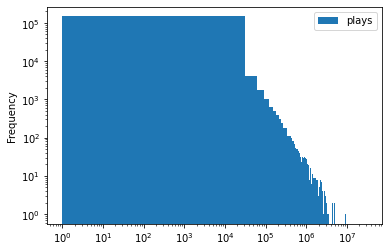

In [9]:
df_360k.groupby('artist').sum('plays').plot(kind='hist',bins=1000, logy=True, logx=True)

#### Save to HDF5 using util function from implicit

We can use their function to save our Last.FM 360K Data in HDF5, in order to use it in the 8th notebook !

In [ ]:
#_hfd5_from_dataframe(df_360k, 'data/360k.hdf5')